In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

from utils.dataset_generator import generate_dataset, ImplicitDataset, TestDataset, SliceDataset
import numpy as np
from sdf import *
import math

@sdf3
def gyroid(w = 3.14159, t=0):
    def f(p):
        q = w*p
        x, y, z = (q[:, i] for i in range(3))
        return (np.cos(x)*np.sin(y) + np.cos(y)*np.sin(z) + np.cos(z)*np.sin(x) - t)
    return f

[pyigl_import] module igl not found. trying to import pyigl


In [3]:
generate_dataset(box(1.0) & gyroid(w=math.pi*4, t=0), N_train=40*40*40, N_test=1e6, name='box_1f0_gyroid_4pi', save_dir='../datasets')

Saved file at ../datasets\box_1f0_gyroid_4pi.stl
ImplicitDataset (64000 points)
SliceDataset (10000 points)
UniformMeshSDFDataset (1000000 points)
RandomMeshSDFDataset[sobol] (3145728 points)


In [19]:
name = 'box_1f0_gyroid_4pi'
train = ImplicitDataset.from_file(f'../datasets/{name}_train.npz', device='cuda')
#test = TestDataset(f'../datasets/{name}_test.npz')
#slice_dataset = SliceDataset.from_file(f'../datasets/{name}_slice.npz')

In [22]:
from utils.dataset_generator import batch_loader

for i in batch_loader(train.points, batch_size=10000):
    print(i.shape)

torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([4000, 3])


In [15]:
from utils.geometry import Mesh
mesh = Mesh(f'../datasets/{name}.stl', doNormalize=True)
bv, _ = mesh.bounding_box()
np.min(bv, axis=0)

array([-0.5, -0.5, -0.5])

In [5]:
print(train)
print(test)
print(slice_dataset)
print(test.random.points.shape)

ImplicitDataset (64000 points)
TestDataset (1000000 points, 3145728 points)
SliceDataset (10000 points)
(3145728, 3)


40


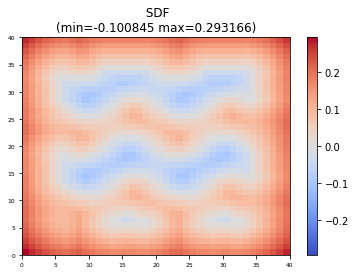

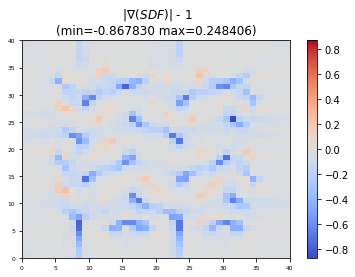

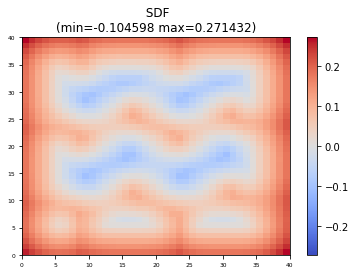

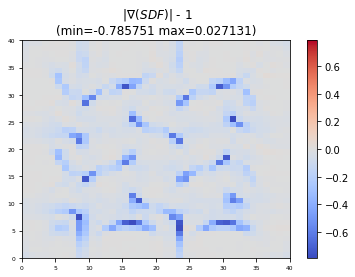

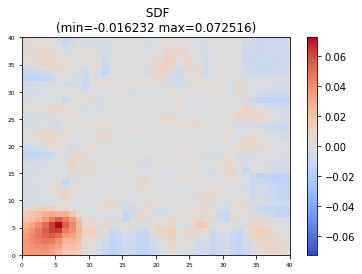

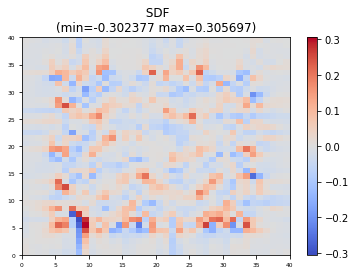

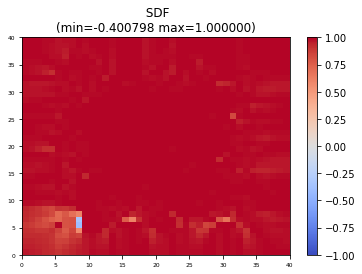

[]

In [6]:
ndim = round(train.sdfs.shape[0]**(1/3))
print(ndim)
points = train.points.reshape((ndim, ndim, ndim, 3))
sdfs  = train.sdfs.reshape((ndim, ndim, ndim))
true_sdfs  = train.true_sdfs.reshape((ndim, ndim, ndim))

dx = points[1,1,1,:] - points[0,0,0,:]
#grad = np.linalg.norm(np.array(np.gradient(sdfs, *dx)), axis=0)
grad = train.grads.reshape((ndim, ndim, ndim, 3))
norm_grad = np.linalg.norm(grad, axis=3)

true_grad = train.true_grads.reshape((ndim, ndim, ndim, 3))
norm_true_grad = np.linalg.norm(true_grad, axis=3)

cosine_similarity = np.einsum('ij,ij->i', train.grads, train.true_grads).reshape((ndim,ndim,ndim)) / norm_grad / norm_true_grad

slice_z = 20
from utils.visualizer import SDFVisualize
visualizer = SDFVisualize()
visualizer._plot(sdfs[:, :, slice_z], norm_grad[:, :, slice_z])
visualizer._plot(true_sdfs[:, :, slice_z], norm_true_grad[:, :, slice_z])
visualizer._plot(sdfs[:, :, slice_z] - true_sdfs[:, :, slice_z])
visualizer._plot(norm_grad[:, :, slice_z] - norm_true_grad[:, :, slice_z])
visualizer._plot(cosine_similarity[:,:,slice_z])


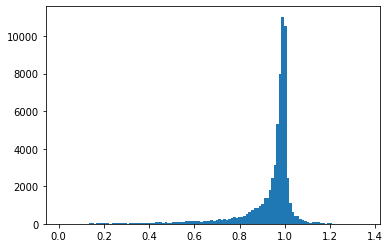

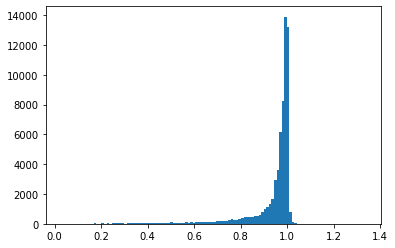

In [7]:
import matplotlib.pyplot as plt
_norm_grad = norm_grad.reshape((ndim**3,))
_norm_true_grad = norm_true_grad.reshape((ndim**3,))
plt.hist(_norm_grad, bins=120)
plt.show()
plt.hist(_norm_true_grad, bins=120)
plt.show()